# Imports

In [1]:
#export
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'exp'))

import json
import yaml
import datetime
import collections
from pathlib import Path
from collections import OrderedDict

import numpy as np
import pandas as pd
from nb_base_exp import *#BaseExperiment, BaseProject, load_txt_log
from config import cfg

In [2]:
import plotly.express as px
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Code

In [4]:
#export
def load_log(path):
    columns = ['date','epoch','acc','val_acc']
    types = [str, np.int32, np.float32, np.float32]
    log_path = list(path.rglob('*/*/log.txt'))[0]

    _, logs = load_txt_log(path=log_path, types=types)

    df = pd.DataFrame(logs, columns=columns)
    df.dropna(inplace=True)
    df = df.astype(dict(zip(columns, types)))

    df['val_acc'].replace(-1., np.NaN, inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.set_index('epoch', inplace=True)
    timeDF=(pd.to_datetime(df['date'].str.strip(), format='%H:%M:%S'))
    del df['date']# = timeDF
    df['duration'] = timeDF - timeDF[0]
    return df

def load_yaml_cfg(path):
    params_path = list(path.rglob('*/*/train.yaml'))[0]
    with open(params_path, 'r') as f:
        d = yaml.safe_load(f)
    d = flatten(d)
    d = OrderedDict(sorted(d.items(), key=lambda x:x[0], reverse=False))
    return d

def load_json_cfg(path):
    params_path = list(path.rglob('*/*/params.json'))[0]
    with open(params_path, 'r') as f:
        d = json.load(f)
    d = flatten(d)
    d = OrderedDict(sorted(d.items(), key=lambda x:x[0], reverse=False))
    return d

def load_cfg(*args, **kwargs):
    return load_json_cfg(*args, **kwargs)

def check_valid(cpath):
    flag_files = set(['log.txt', 'params.json'])
    where_to_look = 'output'
    output = list(Path(cpath).rglob(where_to_look))
    files=[]
    if output:
        files = list(output[0].glob('*/*'))

    return flag_files.issubset(set([f.name for f in files]))



In [5]:
#export
class GenExperiment(BaseExperiment):
    def __init__(self,  path):
        super(GenExperiment, self).__init__(path, log_reader=load_log, cfg_reader=load_cfg)
        self.start_time = self.parse_name()

    def parse_name(self, prefix='run_'):
        date = self.name.strip(prefix)#.rstrip('.lock')
        start_time = datetime.datetime.strptime(date, '%Y_%b_%d_%H_%M_%S_%f')
        return start_time

    def total_time(self):
        return self.log_data['duration'][self.__len__()-1]
    
class GenProject(BaseProject):
    def __init__(self,  root):
        super(GenProject, self).__init__(root, valid_func=check_valid, Experiment=GenExperiment)
    
    def extend_base(self):
        dd = {}
        for run in self.exps:
            run_best = run.best(num=3, col='val_acc')
            #run_best_pct = 100 - int( 100 * (run.total_time() - dur) / run.total_time())
            d = {}
            d['start'] = run.start_time
            d['name'] = run.name
            d['tt'] = run.total_time()
            d['t2b'] = run_best['duration'].values[0]
            d['ba'] = round(run_best.mean()[['acc']].values[0],3)
            d['bva'] = round(run_best.mean()[['val_acc']].values[0],3)
            d['la'] = round(run.log_data['acc'][-10:].mean(),3)
            #d.update(**run.params)
            dd[run.name] = d
        #res_df = pd.DataFrame(results, columns=['Name','duration', 'LRM', 'best_acc', 'best_val', 'best_pct', *run.params.keys()])

        df = pd.DataFrame(dd).T
        df = pd.concat([df,self.base_table()], axis=1)
        df.set_index('start', drop=True, inplace=True)
#         for x in ['tt','t2b']:
#             df[x] = pd.DatetimeIndex(df[x]).strftime("%H:%M:%S")
            
        df['ba'] = df['ba'].astype(float)
        df['la'] = df['la'].astype(float)
        df['bva'] = df['bva'].astype(float)
        df = df.round(4)
        
        
        return df

In [6]:
def plot(cols=None, window=1,limits=[-1,-1], ax=None, x=None):
        if ax is None:
            f,ax = plt.subplots(1)
        if cols is None:
            cols = ['acc']
        if x is not None:
            cols.append(x)
            
        data = e.log_data
        llim, rlim = limits
        rlim = len(data) if rlim <=0 else rlim
        llim = max(0, llim)
        
        
        d = data.iloc[llim:rlim,:]
        d = d.loc[:,cols]
        for c in cols:
            if c != 'duration':
                d[c] = d[c].rolling(window).mean() 
        
        d.plot(figsize=(12,7), ax=ax, x=x)
        
def mod_df(df, col='acc', window=1, div=1):
    d = df.loc[:, [col, 'duration']]
    s = d['duration'].apply(lambda x: x.seconds)/div
    d.loc[:,'duration'] = s
    
    s = d[col].rolling(window).mean()
    d.loc[:,col] = s
    return d

def plot_run(run, col, ax,  window=5):
    d = mod_df(run.log_data, col=col, window=window)
    d.plot('duration', ax=ax)

# Tests

In [45]:
root = Path(cfg.DAG.RUNS)
bp = GenProject(root)
df = bp.extend_base()

In [46]:
df.sort_index(ascending=False).head(10)
#df.sort_values('bva', ascending=False).head(10)

,name,tt,t2b,ba,bva,la,combine_chance,crossover_chance,dec_f0,dec_f1,dec_f2,dec_f3,exp_power,generation_size,generations,mutate_chance,seed,subsample_size
start,,,,,,,,,,,,,,,,,,
2020-05-19 19:22:28.047876,run_2020_May_19_19_22_28_047876,00:00:17,00:00:00,0.084,0.065,0.088,0.5799,0.7467,12,10,8,6,2,200,200,0.0444,0,50
2020-05-19 19:22:21.926511,run_2020_May_19_19_22_21_926511,00:00:21,00:00:21,0.118,0.094,0.118,0.8473,0.5396,12,10,8,6,2,200,200,0.0188,0,50
2020-05-19 19:22:21.909126,run_2020_May_19_19_22_21_909126,00:00:21,00:00:21,0.098,0.070,0.080,0.5381,0.6327,12,10,8,6,2,200,200,0.0239,0,50
2020-05-19 19:14:57.462776,run_2020_May_19_19_14_57_462776,00:07:07,00:06:40,0.310,0.333,0.335,0.5799,0.7467,12,10,8,6,2,200,200,0.0444,0,50
2020-05-19 19:14:57.452274,run_2020_May_19_19_14_57_452274,00:07:02,00:06:22,0.460,0.455,0.452,0.5381,0.6327,12,10,8,6,2,200,200,0.0239,0,50
2020-05-19 19:14:57.434298,run_2020_May_19_19_14_57_434298,00:06:58,00:04:57,0.480,0.492,0.473,0.8473,0.5396,12,10,8,6,2,200,200,0.0188,0,50
2020-05-19 19:03:36.891749,run_2020_May_19_19_03_36_891749,00:06:58,00:06:58,0.461,0.480,0.461,0.8473,0.5396,12,10,8,6,2,200,200,0.0188,0,50
2020-05-19 19:03:36.891492,run_2020_May_19_19_03_36_891492,00:06:58,00:06:58,0.337,0.337,0.339,0.5799,0.7467,12,10,8,6,2,200,200,0.0444,0,50
2020-05-19 19:03:36.851661,run_2020_May_19_19_03_36_851661,00:07:00,00:07:00,0.415,0.470,0.456,0.5381,0.6327,12,10,8,6,2,200,200,0.0239,0,50


0.34992982456140354


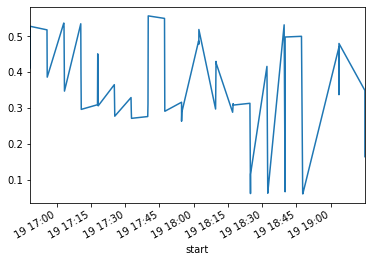

In [44]:
s = df['bva']
print(s.mean())
s.plot()

In [18]:
df['tt'].sum()

Timedelta('0 days 05:54:57')

In [19]:
df = df[df['ba']>.3]
df.shape

(32, 18)

In [20]:
# df = df[df['ba']<.3]
# df.shape
# names = df.sort_index()['name'][:30].values
# p = Path('./cycler_runs/')
# for name in names:
#     pi = p/name
#     shutil.rmtree(pi)

In [24]:
k = 'bva'
tdf = df.sort_index(ascending=False)#[:10]
fig = px.parallel_coordinates(tdf, color=k,
              dimensions=['combine_chance', 'crossover_chance', 'mutate_chance', 'exp_power',
                         #'dec_f0','dec_f1','dec_f2','dec_f3',
                          'bva'],
              color_continuous_scale=px.colors.diverging.Tealrose,
              range_color=[0.4,df[k].max()],
              color_continuous_midpoint=.25)
fig.show()

In [62]:
plot_df = df#[:1]
#top = df.sort_values(by='bva', ascending=False)[:5]
#plot_df = pd.concat([plot_df,top])

In [67]:
df.sort_values(by='bva', ascending=False)[:5]

,name,tt,t2b,ba,bva,la,combine_chance,crossover_chance,dec_f0,dec_f1,dec_f2,dec_f3,exp_power,generation_size,generations,mutate_chance,seed,subsample_size
start,,,,,,,,,,,,,,,,,,
2020-05-19 17:40:04.711211,run_2020_May_19_17_40_04_711211,00:06:56,00:06:18,0.542,0.557,0.539,0.7866,0.5402,12,10,8,6,15,200,200,0.0037,0,50
2020-05-19 17:47:12.533388,run_2020_May_19_17_47_12_533388,00:06:58,00:06:58,0.536,0.550,0.538,0.9484,0.7651,12,10,8,6,15,200,200,0.0036,0,50
2020-05-19 17:03:05.653555,run_2020_May_19_17_03_05_653555,00:07:01,00:06:27,0.526,0.537,0.533,0.6986,0.0704,12,10,8,6,6,200,200,0.0073,0,50
2020-05-19 17:10:31.817967,run_2020_May_19_17_10_31_817967,00:07:06,00:07:06,0.526,0.535,0.522,0.6986,0.0704,12,10,8,6,6,200,200,0.0073,0,50
2020-05-19 18:39:36.208843,run_2020_May_19_18_39_36_208843,00:07:00,00:07:00,0.554,0.532,0.546,0.4325,0.7717,12,10,8,6,2,200,200,0.0087,0,50


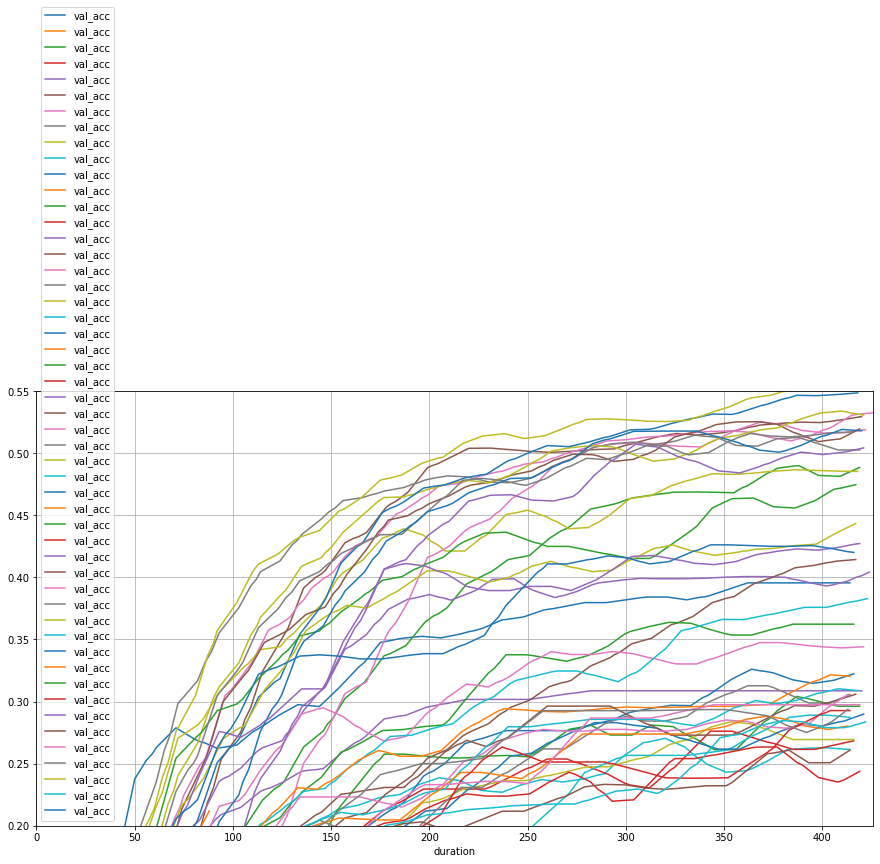

In [66]:
rs = bp.exps
f, a = plt.subplots(1, figsize=(15,8))
#l_lim, r_lim = 0, 1000

rsp = [r for r in rs if r.name in plot_df.name.values]

[plot_run(r, col='val_acc', ax=a, window=15) for r in rsp]

#a.legend([r.name for r in rsp])
#axs.legend(['Validation', 'Train'])

#a.set_xticks(np.arange(l_lim, 700, 10))
#a.set_yticks(np.arange(0.1, .9, 0.05))
plt.ylim(.2,.55)
plt.grid()

# Exports

In [11]:
!python3 extra/n2s.py gen_exp.ipynb 

Converted gen_exp.ipynb to exp/nb_gen_exp.py
